### Note: 
using 4 sample real data from PCSWMM outputs 

## We ran out of memory !!!

In [1]:
from Dataset_Class import Pluvial_Dataset

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

In [15]:
rainfall_path = "Data_Sample/synthetic_rainfall_variable_duration_2.xlsx"
flood_folder = "Data_Sample/PCSWMM_Output_Files"
building_path = "Data_Sample/PCSWMM_Output_Files/1/1DepthFLT/1Depth.FLT"
curve_path = "Data_Sample/PCSWMM_Output_Files/1/1DepthTiff/1DepthT.TIF"
DEM_path = "Data_Sample/PCSWMM_Output_Files/1/1DepthTiff/1DepthT.TIF"
time_of_concentration = 3.5  # it is an example

In [16]:
dataset = Pluvial_Dataset(
    rainfall_path=rainfall_path,
    flood_folder=flood_folder,
    building_path=building_path,
    curve_path=curve_path,
    DEM_path = DEM_path,
    time_of_concentration=time_of_concentration
)

In [19]:
dataset[0]

{'rainfall': tensor([[0.1434],
         [0.1117],
         [0.0091],
         [0.1754],
         [0.1486],
         [0.0000],
         [0.3867],
         [0.0000],
         [0.2893],
         [0.2018],
         [0.0000],
         [0.0000],
         [0.0189],
         [0.3409],
         [0.1802],
         [0.0095],
         [0.1336],
         [0.0000],
         [0.0154],
         [0.4016],
         [1.2034],
         [0.9403],
         [0.6539],
         [0.8425],
         [0.0000],
         [0.2624],
         [0.3070],
         [0.1775],
         [0.1082],
         [0.1744],
         [0.1234],
         [0.1094],
         [0.0000],
         [0.0388],
         [0.0498],
         [0.0147],
         [0.0000],
         [0.0013],
         [0.3158],
         [0.0000],
         [0.1619],
         [0.4340],
         [0.4784],
         [0.1748],
         [0.2742],
         [0.0287],
         [0.2212],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],


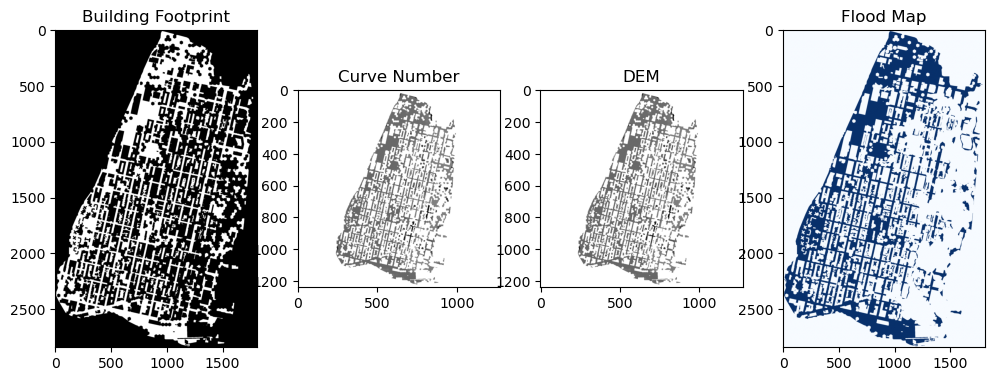

In [44]:
# Visualize a sample in the Dataset 
sample = dataset[3]
plt.figure(figsize=(12, 5))
plt.subplot(1, 4, 1)
plt.imshow(sample["buildings"][0], cmap="gray")
plt.title("Building Footprint")
plt.subplot(1, 4, 2)
plt.imshow(sample["curve"][0], cmap="gray")
plt.title("Curve Number")
plt.subplot(1, 4, 3)
plt.imshow(sample["DEM"][0], cmap="gray")
plt.title("DEM")
plt.subplot(1, 4, 4)
plt.imshow(sample["flood"][0], cmap="Blues")
plt.title("Flood Map")
plt.show()


In [20]:
# Model Structure:

class FloodPredictor(nn.Module):
    def __init__(self, seq_len=24, grid_size=32, hidden_dim=64):
        super(FloodPredictor, self).__init__()
        self.grid_size = grid_size

        # LSTM for rainfall sequence
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_dim, batch_first=True)
        
        # FC for rainfall duration, Curve Number, and time of concentration
        self.duration_fc = nn.Linear(1, hidden_dim)
        self.tc_fc = nn.Linear(1, hidden_dim)  # time of concentration
        
        # CNN for Curve Number
        self.curve_encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        # CNN for DEM
        self.DEM_encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        # CNN for building map
        self.building_encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        # Fusion layer to combine time features + duration + building features
        self.fusion_fc = nn.Linear(hidden_dim * 3, grid_size * grid_size)

        # Decoder CNN to predict flood map
        self.decoder = nn.Sequential(
            nn.Conv2d(97, 32, kernel_size=3, padding=1),  # 32 from CNN + 32 from CN + 32 from DEM + 1 from broadcasted fusion
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=1),  # output 1 channel (probability)
            nn.Sigmoid()
        )

    def forward(self, rainfall, duration, curve_num, DEM, time_conc, buildings):
        B = rainfall.size(0)

        # Encode rainfall time series
        lstm_out, _ = self.lstm(rainfall)
        rainfall_feat = lstm_out[:, -1, :]  # last time step

        # Encode duration
        duration_feat = F.relu(self.duration_fc(duration))
        tc_feat = self.tc_fc(time_conc)

        # Combine rainfall + duration
        fused = torch.cat([rainfall_feat, duration_feat, tc_feat], dim=1)
        fused = F.relu(self.fusion_fc(fused))  # (B, H*W)
        fused = fused.view(B, 1, self.grid_size, self.grid_size)  # reshape to spatial

        # Encode Curve Number map
        curve_feat = self.curve_encoder(curve_num)

        # Encode DEM map
        DEM_feat = self.DEM_encoder(DEM)

        # Encode building map
        #buildings = buildings.unsqueeze(1)  # (B, 1, H, W)
        building_feat = self.building_encoder(buildings)

        # Concatenate spatial features
        combined = torch.cat([building_feat, curve_feat, DEM_feat, fused], dim=1)  # (B, 97, H, W)

        # Decode to flood map
        flood_pred = self.decoder(combined).squeeze(1)  # (B, H, W)
        return flood_pred


In [26]:
class FloodPredictor(nn.Module):
    def __init__(self, seq_len=24, grid_size=32, hidden_dim=64):
        super(FloodPredictor, self).__init__()
        self.grid_size = grid_size

        # LSTM for rainfall sequence
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_dim, batch_first=True)
        
        # FC for rainfall duration, Curve Number, and time of concentration
        self.duration_fc = nn.Linear(1, hidden_dim)
        self.tc_fc = nn.Linear(1, hidden_dim)  # time of concentration
        
        # CNN for Curve Number
        self.curve_encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        # CNN for DEM
        self.DEM_encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        # CNN for building map
        self.building_encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        # Fusion layer to combine time features + duration + concentration
        self.fusion_fc = nn.Linear(hidden_dim * 3, grid_size * grid_size)

        # Decoder CNN to predict flood map
        self.decoder = nn.Sequential(
            nn.Conv2d(97, 32, kernel_size=3, padding=1),  # 32 from each spatial encoder + 1 fused
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=1),  # output 1 channel (probability)
            nn.Sigmoid()
        )

    def forward(self, rainfall, duration, curve_num, DEM, time_conc, buildings):
        B = rainfall.size(0)
        target_H, target_W = buildings.shape[-2], buildings.shape[-1]  # use buildings as reference
    
        # Encode rainfall sequence
        lstm_out, _ = self.lstm(rainfall)
        rainfall_feat = lstm_out[:, -1, :]  # (B, hidden_dim)
    
        # Encode duration and time of concentration
        duration_feat = F.relu(self.duration_fc(duration))
        tc_feat = F.relu(self.tc_fc(time_conc))
    
        # Fuse and reshape
        fused = torch.cat([rainfall_feat, duration_feat, tc_feat], dim=1)  # (B, 3 * hidden_dim)
        fused = F.relu(self.fusion_fc(fused))  # (B, grid_size*grid_size)
        fused = fused.view(B, 1, self.grid_size, self.grid_size)
        fused = F.interpolate(fused, size=(target_H, target_W), mode='bilinear', align_corners=False)
    
        # Encode and resize spatial features
        curve_feat = self.curve_encoder(curve_num)
        curve_feat = F.interpolate(curve_feat, size=(target_H, target_W), mode='bilinear', align_corners=False)
    
        DEM_feat = self.DEM_encoder(DEM)
        DEM_feat = F.interpolate(DEM_feat, size=(target_H, target_W), mode='bilinear', align_corners=False)
    
        building_feat = self.building_encoder(buildings)
        building_feat = F.interpolate(building_feat, size=(target_H, target_W), mode='bilinear', align_corners=False)
    
        # Concatenate along channel dimension
        combined = torch.cat([building_feat, curve_feat, DEM_feat, fused], dim=1)  # (B, 97, H, W)
    
        # Decode to flood prediction
        flood_pred = self.decoder(combined).squeeze(1)  # (B, H, W)
        return flood_pred



In [21]:
# Modified loss function

def masked_bce_loss(pred, target, mask):
    # Compute element-wise BCE loss
    bce = F.binary_cross_entropy(pred, target, reduction='none')
    
    # Apply mask
    masked_bce = bce * mask

    # Avoid division by zero
    loss = masked_bce.sum() / mask.sum().clamp(min=1.0)
    return loss


In [ ]:
# Setup
model = FloodPredictor()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#criterion = nn.BCELoss()
num_epochs = 10

# Dataloader
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Creating mask for loss function
mask = test_dataset[1]["buildings"]

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        rain = batch['rainfall']
        dur = batch['duration']
        curve = batch['curve']
        DEM = batch['DEM']
        tc = batch['tc']
        build = batch['buildings']
        flood = batch['flood']

        pred = model(rain, dur, curve, DEM, tc, build)
        loss = masked_bce_loss(pred, flood, mask)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")


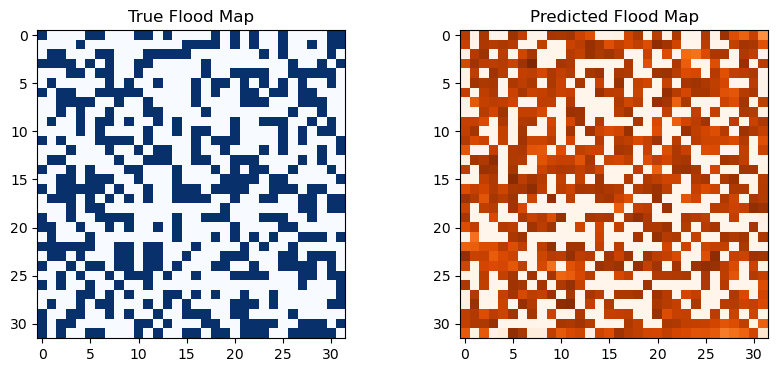

In [15]:
# Visualize a sample prediction for test dataset
model.eval()
sample = test_dataset[0]
with torch.no_grad():
    pred = model(sample["rainfall"].unsqueeze(0), sample["duration"].unsqueeze(0), sample["curve"].unsqueeze(0), 
                 sample["time_conc"].unsqueeze(0), sample["buildings"].unsqueeze(0))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(sample["flood"], cmap="Blues")
plt.title("True Flood Map")
plt.subplot(1, 2, 2)
plt.imshow(pred.squeeze().cpu().numpy(), cmap="Oranges")
plt.title("Predicted Flood Map")
plt.show()


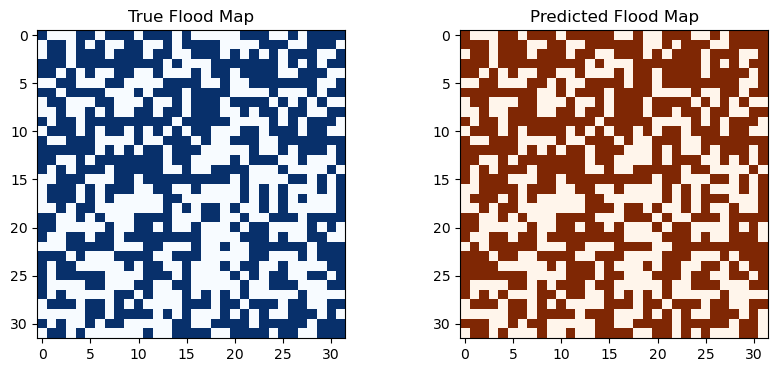

In [16]:
# Visualize a sample prediction for test dataset
model.eval()
sample = test_dataset[9]
with torch.no_grad():
    pred = model(sample["rainfall"].unsqueeze(0), sample["duration"].unsqueeze(0), sample["curve"].unsqueeze(0), 
                 sample["time_conc"].unsqueeze(0), sample["buildings"].unsqueeze(0))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(sample["flood"], cmap="Blues")
plt.title("True Flood Map")
plt.subplot(1, 2, 2)
predicted_flood_map = (pred.squeeze().cpu().numpy() > 0.5).astype(np.float32)
plt.imshow(predicted_flood_map, cmap="Oranges")
plt.title("Predicted Flood Map")
plt.show()


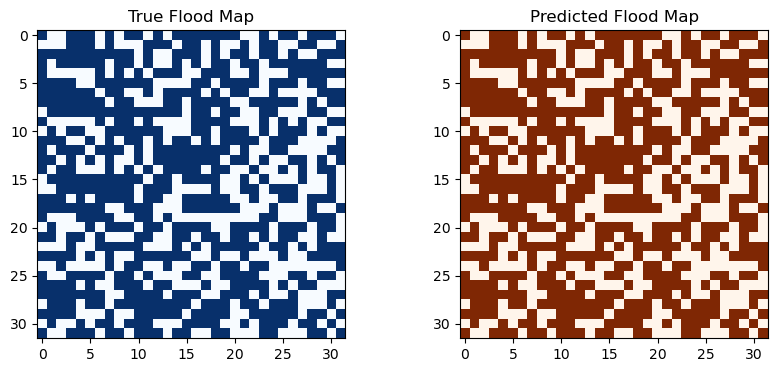

In [19]:
# Visualize a sample prediction for test dataset
model.eval()
sample = test_dataset[5]
with torch.no_grad():
    pred = model(sample["rainfall"].unsqueeze(0), sample["duration"].unsqueeze(0), sample["curve"].unsqueeze(0), 
                 sample["time_conc"].unsqueeze(0), sample["buildings"].unsqueeze(0))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(sample["flood"], cmap="Blues")
plt.title("True Flood Map")
plt.subplot(1, 2, 2)
predicted_flood_map = (pred.squeeze().cpu().numpy() > 0.5).astype(np.float32)
plt.imshow(predicted_flood_map, cmap="Oranges")
plt.title("Predicted Flood Map")
plt.show()

In [20]:
def evaluate_model(model, dataset, threshold=0.5):
    
    '''
    calculate flood map for test dataset and copute confusion matrix, accuracy, precision, and recall.
    
    '''
    
    model.eval()
    y_true_all = []
    y_pred_all = []

    with torch.no_grad():
        for i in range(len(dataset)):
            sample = dataset[i]
            rain = sample["rainfall"].unsqueeze(0)
            dur = sample["duration"].unsqueeze(0)
            curve = sample["curve"].unsqueeze(0)
            time_conc = sample["time_conc"].unsqueeze(0)
            build = sample["buildings"].unsqueeze(0)

            pred = model(rain, dur, curve, time_conc, build)
            pred_binary = (pred.squeeze().cpu().numpy() > threshold).astype(int)
            true_binary = sample["flood"].numpy().astype(int)

            y_pred_all.extend(pred_binary.flatten())
            y_true_all.extend(true_binary.flatten())

    # Convert to numpy arrays
    y_true_all = np.array(y_true_all)
    y_pred_all = np.array(y_pred_all)

    # Confusion matrix
    cm = confusion_matrix(y_true_all, y_pred_all)
    acc = accuracy_score(y_true_all, y_pred_all)
    prec = precision_score(y_true_all, y_pred_all)
    rec = recall_score(y_true_all, y_pred_all)

    return cm, acc, prec, rec, y_true_all, y_pred_all


In [21]:
def plot_confusion_matrix(y_true, y_pred, labels=["Not Flooded", "Flooded"], title="Confusion Matrix"):
    '''
    Visualize the cofusion matrix
    
    '''
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(3, 3))
    ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=labels, yticklabels=labels, cbar=False)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(2)
        spine.set_color("black")
        
    plt.tight_layout()
    plt.show()


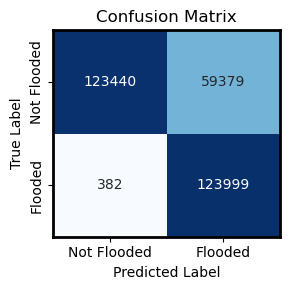

Confusion Matrix:
 [[123440  59379]
 [   382 123999]]
Accuracy:  0.805
Precision: 0.676
Recall:    0.997


In [22]:
cm, acc, prec, rec, y_true_all, y_pred_all = evaluate_model(model, test_dataset)
plot_confusion_matrix(y_true_all, y_pred_all)
print("Confusion Matrix:\n", cm)
print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")